This project uses basic timestamped Twitter datasets that show the number of twitter mentions of a specific company every five minutes over a time period of a few months. (dataset available here: https://github.com/numenta/NAB/tree/master/data/realTweets). To find a dataset, I first picked out a couple of popular companies and looked at the basic time-stamped data to find a dataset that did not have large variability. I then used feature engineering to pull out the mention difference between every entry on the list as well as the day of the week that the time period was a part of to account for weekly trends. Finally, I used two different methods to detect anomalies within the dataset: the isolation forest and local outlier factor models.

In [38]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

In [39]:
df_AMZN = pd.read_csv(r'Twitter_volume_AMZN.csv', parse_dates = ['timestamp'])
df_GOOG = pd.read_csv(r'Twitter_volume_GOOG.csv', parse_dates = ['timestamp'])

df_AMZN

,timestamp,value
0,2015-02-26 21:42:53,57
1,2015-02-26 21:47:53,43
2,2015-02-26 21:52:53,55
3,2015-02-26 21:57:53,64
4,2015-02-26 22:02:53,93
...,...,...
15826,2015-04-22 20:32:53,51
15827,2015-04-22 20:37:53,54
15828,2015-04-22 20:42:53,46
15829,2015-04-22 20:47:53,56


Text(0, 0.5, 'number of tweets')

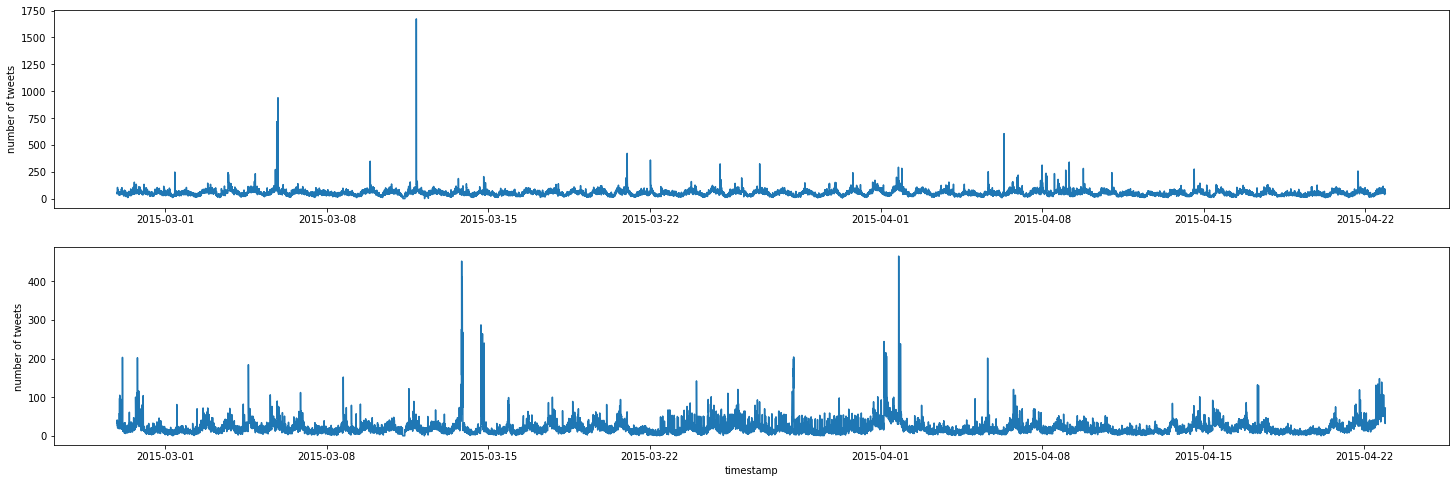

In [40]:
plt.figure(figsize=(25,8))

plt.subplot(2, 1, 1)
plt.plot(df_AMZN['timestamp'], df_AMZN['value'])
plt.ylabel('number of tweets')

plt.subplot(2, 1, 2)
plt.plot(df_GOOG['timestamp'], df_GOOG['value'])
plt.xlabel('timestamp')
plt.ylabel('number of tweets')

It would appear as though the Amazon data on the top is less erratic than the Google data, which is on the bottom. As a result, I decided to use the Amazon dataset due to the lower amount of relative noise. 

In [41]:
#Here, I found the mention difference between each row and referred to it as 'Tweet_gain'
df_AMZN['Tweet_gain'] = df_AMZN['value'].diff()
df_AMZN['Tweet_gain'] = df_AMZN['Tweet_gain'].fillna(0)

#Here, I used the time data to pull out the day of the week. To feed it into the models, I onehot encoded each day. Day 0 corresponds to Monday, with a total of seven days for each week.
#The day of the week is valuable in this case due to the fact that it may be able to catch weekly trends.
df_AMZN['Day_of_Week'] = df_AMZN['timestamp'].dt.dayofweek
df_AMZN['Day_of_Week'] = df_AMZN['Day_of_Week'].astype(str)
df_AMZN = pd.get_dummies(df_AMZN, columns=['Day_of_Week'], prefix = 'day')

df_AMZN


,timestamp,value,Tweet_gain,day_0,day_1,day_2,day_3,day_4,day_5,day_6
0,2015-02-26 21:42:53,57,0.0,0,0,0,1,0,0,0
1,2015-02-26 21:47:53,43,-14.0,0,0,0,1,0,0,0
2,2015-02-26 21:52:53,55,12.0,0,0,0,1,0,0,0
3,2015-02-26 21:57:53,64,9.0,0,0,0,1,0,0,0
4,2015-02-26 22:02:53,93,29.0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
15826,2015-04-22 20:32:53,51,-15.0,0,0,1,0,0,0,0
15827,2015-04-22 20:37:53,54,3.0,0,0,1,0,0,0,0
15828,2015-04-22 20:42:53,46,-8.0,0,0,1,0,0,0,0
15829,2015-04-22 20:47:53,56,10.0,0,0,1,0,0,0,0


In [42]:
df_AMZN.dtypes


timestamp     datetime64[ns]
value                  int64
Tweet_gain           float64
day_0                  uint8
day_1                  uint8
day_2                  uint8
day_3                  uint8
day_4                  uint8
day_5                  uint8
day_6                  uint8
dtype: object

Now that the data has been worked up, I went on to train the first model, isolation forest. I used the anomaly identification abilities of the model to directly label it in the dataset, then used the label to graph the "normal" and "anomalous" entries separately. 

In [43]:
clf=IsolationForest()
AMZN_test = df_AMZN.drop(columns=['timestamp'])
clf.fit(AMZN_test)

IsolationForest()

In [44]:
df_AMZN['anomaly'] = pd.Series(clf.predict(AMZN_test))
df_AMZN

,timestamp,value,Tweet_gain,day_0,day_1,day_2,day_3,day_4,day_5,day_6,anomaly
0,2015-02-26 21:42:53,57,0.0,0,0,0,1,0,0,0,1
1,2015-02-26 21:47:53,43,-14.0,0,0,0,1,0,0,0,1
2,2015-02-26 21:52:53,55,12.0,0,0,0,1,0,0,0,1
3,2015-02-26 21:57:53,64,9.0,0,0,0,1,0,0,0,1
4,2015-02-26 22:02:53,93,29.0,0,0,0,1,0,0,0,-1
...,...,...,...,...,...,...,...,...,...,...,...
15826,2015-04-22 20:32:53,51,-15.0,0,0,1,0,0,0,0,1
15827,2015-04-22 20:37:53,54,3.0,0,0,1,0,0,0,0,1
15828,2015-04-22 20:42:53,46,-8.0,0,0,1,0,0,0,0,1
15829,2015-04-22 20:47:53,56,10.0,0,0,1,0,0,0,0,1


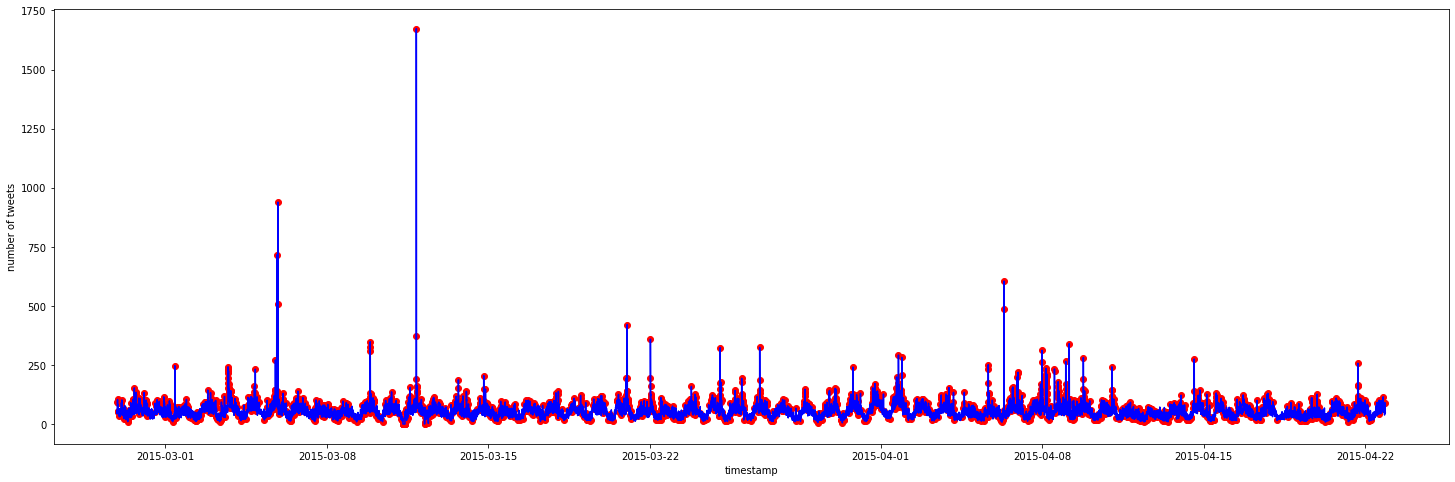

In [45]:
anom = df_AMZN.loc[df_AMZN['anomaly'] == -1, ['timestamp', 'value']]

plt.figure(figsize=(25,8))
plt.ylabel('number of tweets')
plt.xlabel('timestamp')
plt.scatter(anom['timestamp'], anom['value'], color='red')
plt.plot(df_AMZN['timestamp'], df_AMZN['value'], color='blue')

plt.show()

From the figure shown, it is obvious that the given data was not given enough features to allow a separation between the normal data and the anomalies. A much better way to approach this would have been to include values for the hour as well as the day for each tweet, as I was under the false impression that raw time data could have been used in the training process. With more information by the hour, I may have been able to get a better-looking spread of anomalies.

Below is my attempt at training a Local Outlier Factor model (LOF). I used a very similar approach to the isolation forest for training this model. 

In [46]:
LOF = LocalOutlierFactor()
LOF_fit = LOF.fit_predict(AMZN_test)

In [47]:
df_AMZN = df_AMZN.drop(columns=['anomaly'])
df_AMZN['anomaly'] = pd.Series(LOF_fit)

df_AMZN

,timestamp,value,Tweet_gain,day_0,day_1,day_2,day_3,day_4,day_5,day_6,anomaly
0,2015-02-26 21:42:53,57,0.0,0,0,0,1,0,0,0,1
1,2015-02-26 21:47:53,43,-14.0,0,0,0,1,0,0,0,1
2,2015-02-26 21:52:53,55,12.0,0,0,0,1,0,0,0,1
3,2015-02-26 21:57:53,64,9.0,0,0,0,1,0,0,0,1
4,2015-02-26 22:02:53,93,29.0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
15826,2015-04-22 20:32:53,51,-15.0,0,0,1,0,0,0,0,1
15827,2015-04-22 20:37:53,54,3.0,0,0,1,0,0,0,0,1
15828,2015-04-22 20:42:53,46,-8.0,0,0,1,0,0,0,0,1
15829,2015-04-22 20:47:53,56,10.0,0,0,1,0,0,0,0,1


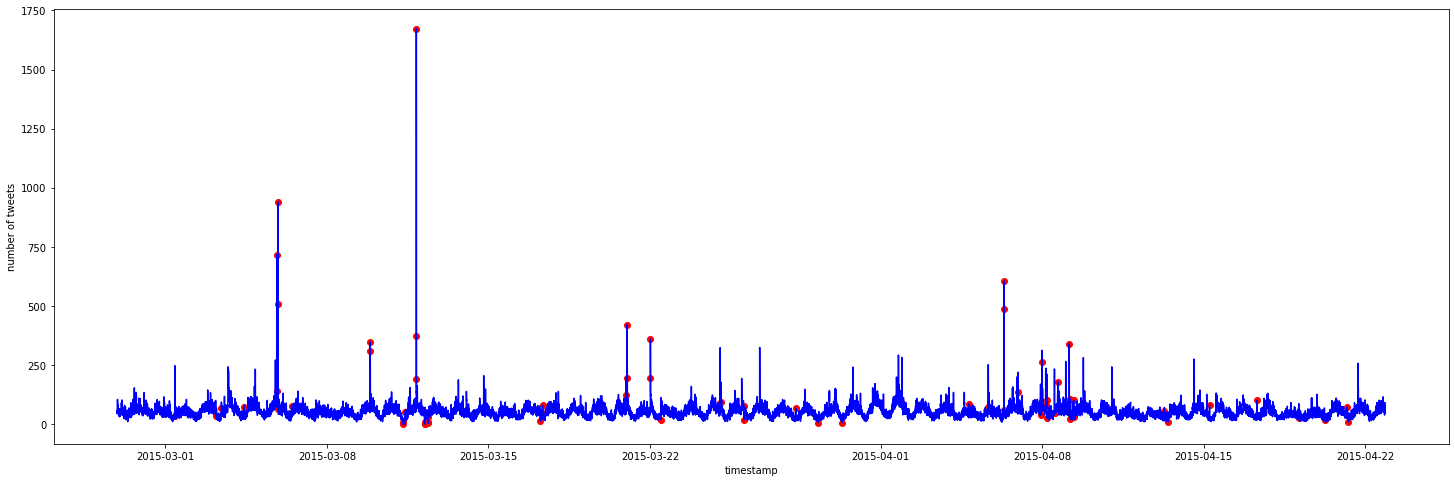

In [48]:
anom = df_AMZN.loc[df_AMZN['anomaly'] == -1, ['timestamp', 'value']]
plt.figure(figsize=(25,8))
plt.ylabel('number of tweets')
plt.xlabel('timestamp')
plt.scatter(anom['timestamp'], anom['value'], color='red')
plt.plot(df_AMZN['timestamp'], df_AMZN['value'], color='blue')

plt.show()

From the appearance of the number of anomalies, it appears as though the LOF model is more accurate at separating anomalies from normal data. However, the threshold for identifying anomalies seems to be lower than that of the isolation forest, as there seem to be some spikes in data that have been ignored by the LOF model. If I wanted to go deeper into the analysis of either model, then I could try altering the default values of the hyperparameters of each model as well as doing a more thorough job of engineering features to account for hourly shifts in Twitter activity. 